<h1>loading data</h1>

In [1]:
import os
import re

import pandas as pd

from datetime import datetime as dt

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

data_dir = '/Users/boyuliu/pyprojects/Joann/Joann-Thailand-Project/notebooks/datasets/new_dataset/'
raw_demand_3yrs = pd.read_csv(data_dir + 'raw_demand_3yrs.csv')
cases1 = pd.read_csv(data_dir + 'cases_boyu_incl.csv')
cases2 = pd.read_csv(data_dir + 'cases_boyu_excl.csv')
cases3 = pd.read_csv(data_dir + 'cases_joann_incl.csv')
cases4 = pd.read_csv(data_dir + 'cases_joann_excl.csv')

provinces = pd.read_csv(data_dir + 'provinces.csv')

merge_method = 'right'

In [2]:
raw_demand_3yrs.head()

,province,total,week,year,industry,male,female,year_week
0,Phra Nakhon Si Ayutthaya,50,16,2017,Construction,35,15,2017-16
1,Bangkok,15,48,2017,Construction,15,0,2017-48
2,Saraburi,20,16,2017,Food and Beverage,12,8,2017-16
3,Bangkok,100,5,2017,Construction,60,40,2017-05
4,Bangkok,100,5,2017,Construction,60,40,2017-05


In [3]:
demand_data = raw_demand_3yrs.groupby(['province','year_week']).sum()['total'].reset_index().rename(columns={'total':'total_demand'})
demand_data

,province,year_week,total_demand
0,Amnat Charoen,2019-21,15
1,Amnat Charoen,2020-05,30
2,Ang Thong,2017-20,50
3,Ang Thong,2017-22,10
4,Ang Thong,2017-31,13
...,...,...,...
3528,Uttaradit,2019-37,2
3529,Uttaradit,2019-40,6
3530,Uttaradit,2020-09,3
3531,Yasothon,2018-43,10


<h1>combine demand data with wv data classification 1</h1>

In [4]:
def date_to_year_week(d):
    year_week = dt.strptime(d, '%Y-%m-%d').strftime('%Y-%W')
    yr, wk = year_week.split('-')
    return '%s-%02d' % (yr, (int(wk)+1))
    
cases_data = {
    'wv_cases1':cases1,
    'wv_cases2':cases2,
    'wv_cases3':cases3,
    'wv_cases4':cases4
}
wv_data_file = 'wv_cases1'
wv_data = cases_data[wv_data_file]
wv_data['year_week'] = wv_data['created'].apply(date_to_year_week)
print(wv_data.shape)
wv_data.sample(5)

(10467, 16)


,created,client_ethnicity_id,client_gender_id,client_nationality_id,client_status_id,country_id,district_id,province_id,client_origin_country_id,client_origin_province_id,supplier_id,kpi_id,id,Boyu - abuse including RA,abuse,year_week
9813,2020-11-11,11.0,2.0,1.0,2.0,8.0,1170.0,123.0,5.0,53.0,227.0,NaN,NaN,NaN,False,2020-46
7311,2020-07-01,1.0,1.0,1.0,1.0,8.0,534.0,70.0,NaN,NaN,1083.0,4.0,4.0,1.0,True,2020-27
9974,2020-11-15,1.0,2.0,1.0,2.0,8.0,1165.0,121.0,5.0,53.0,1083.0,NaN,NaN,NaN,False,2020-46
4279,2019-12-07,1.0,1.0,1.0,3.0,8.0,375.0,105.0,8.0,50.0,1083.0,40.0,40.0,0.0,False,2019-49
2185,2019-07-17,1.0,2.0,1.0,3.0,8.0,NaN,70.0,8.0,NaN,5685.0,18.0,18.0,1.0,True,2019-29


In [5]:
cols_lean = ['province_id', 'year_week', 'abuse']
phone_access_correction = wv_data.loc[:, cols_lean].copy()

total_trend = phone_access_correction.groupby(['province_id', 'year_week']).count()['abuse'].reset_index()
total_trend.rename(columns={'abuse':'wv_count'}, inplace=True)
total_trend = total_trend.set_index(['province_id', 'year_week']).T.squeeze()

numerator = phone_access_correction.groupby(['province_id', 'year_week']).sum()['abuse'].reset_index()
numerator = numerator.set_index(['province_id', 'year_week']).T.squeeze()

percent_abuse = numerator.divide(total_trend, fill_value=0)
percent_abuse = pd.DataFrame(percent_abuse).reset_index()

percent_abuse = percent_abuse.rename(columns={0: 'perc_abuse'})
percent_abuse_m = pd.merge(percent_abuse, total_trend, on=['province_id', 'year_week'])
percent_abuse_m = pd.merge(percent_abuse_m, provinces, how='outer', left_on='province_id', right_on='id', indicator=True)
percent_abuse_m._merge.value_counts()

both          1801
left_only      155
right_only      16
Name: _merge, dtype: int64

In [6]:
percent_abuse_m[percent_abuse_m._merge!='both'].province_id.unique()

array([  8.,  21.,  24.,  39.,  44.,  46.,  48.,  49.,  50.,  51.,  52.,
        53.,  54.,  55.,  56.,  57.,  58.,  59.,  60.,  61., 140.,  nan])

In [7]:
percent_abuse_m[percent_abuse_m._merge!='both'].id.unique()

array([ nan,  66.,  78.,  92.,  93., 100., 102., 103., 106., 107., 108.,
       110., 130., 132., 134., 136., 138.])

In [8]:
cols_lean = ['province_id', 'year_week', 'abuse']
phone_access_correction = wv_data.loc[:, cols_lean].copy()

total_trend = phone_access_correction.groupby(['province_id', 'year_week']).count()['abuse'].reset_index()
total_trend.rename(columns={'abuse':'wv_count'}, inplace=True)
total_trend = total_trend.set_index(['province_id', 'year_week']).T.squeeze()

numerator = phone_access_correction.groupby(['province_id', 'year_week']).sum()['abuse'].reset_index()
numerator = numerator.set_index(['province_id', 'year_week']).T.squeeze()

percent_abuse = numerator.divide(total_trend, fill_value=0)
percent_abuse = pd.DataFrame(percent_abuse).reset_index()

percent_abuse = percent_abuse.rename(columns={0: 'perc_abuse'})
percent_abuse_m = pd.merge(percent_abuse, total_trend, on=['province_id', 'year_week'])
percent_abuse_m = pd.merge(percent_abuse_m, provinces, how='inner', left_on='province_id', right_on='id')
percent_abuse_m = percent_abuse_m.drop(['province_id','id'], axis=1).rename(columns={'name': 'province'})

percent_abuse_m.to_csv(data_dir + '%s.csv' % wv_data_file, index=False)
percent_abuse_m.head()

,year_week,perc_abuse,wv_count,province
0,2018-45,0.0,1,Chiang Mai
1,2018-49,1.0,7,Chiang Mai
2,2019-05,0.0,1,Chiang Mai
3,2019-30,0.0,2,Chiang Mai
4,2019-31,0.0,2,Chiang Mai


In [9]:
print(demand_data.shape, demand_data.year_week.max(), demand_data.year_week.min())
print(percent_abuse_m.shape, percent_abuse_m.year_week.max(), percent_abuse_m.year_week.min())

(3533, 3) 2020-09 2017-01
(1801, 4) 2020-50 2018-36


In [10]:
min_week = '2018-45'
max_week = '2020-09'

df = pd.merge(demand_data, percent_abuse_m, on=['province','year_week'], how=merge_method)
df['total_demand'].fillna(0, inplace=True)
df['perc_abuse'].fillna(0, inplace=True)
df['wv_count'].fillna(0, inplace=True)

df = df[(df['year_week']>=min_week) & (df['year_week']<=max_week)]
print('duplicates:', df[df.duplicated(['province','year_week'])].shape[0])
df

duplicates: 0


,province,year_week,total_demand,perc_abuse,wv_count
6,Bangkok,2018-45,756.0,0.000000,7
7,Bangkok,2018-46,992.0,0.083333,12
8,Bangkok,2018-47,628.0,0.000000,8
9,Bangkok,2018-48,970.0,0.000000,8
10,Bangkok,2018-49,712.0,0.071429,14
...,...,...,...,...,...
1764,Surat Thani,2019-51,0.0,0.485294,68
1765,Surat Thani,2019-52,0.0,0.666667,3
1766,Surat Thani,2020-02,0.0,0.000000,1
1792,Nong Khai,2019-32,0.0,0.000000,1


In [11]:
all_weeks = sorted(df.year_week.unique())
# all_weeks

In [12]:
# all_weeks = ['2018-{:02d}'.format(i) for i in range(45, 53)] + \
#             ['2019-{:02d}'.format(i) for i in range(1, 54)] + \
#             ['2020-{:02d}'.format(i) for i in range(1, 10)]

provinces_list = sorted(df.province.unique().tolist())

df_filled = df.copy()

for prov in provinces_list:
    loc_weeks = df[df.province==prov].year_week.tolist()
    missed_weeks = [i for i in all_weeks if i not in loc_weeks]
    missed_num = len(missed_weeks)
    data_to_add = pd.DataFrame(data={'province': [prov]*missed_num,
                                    'year_week': missed_weeks,
                                    'total_demand': [0]*missed_num,
                                    'perc_abuse': [0]*missed_num,
                                    'wv_count': [0]*missed_num})
    df_filled = df_filled.append(data_to_add, sort=False)
    
df_filled = df_filled.sort_values(['province','year_week'])
print(df_filled.shape)

(3990, 5)


In [13]:
for loc in provinces_list:
    loc_weeks = df_filled[df_filled.province==loc].year_week.tolist()
    missed_weeks = [i for i in all_weeks if i not in loc_weeks]
    missed_num = len(missed_weeks)
    if missed_num > 0:
        print(loc, missed_num)
        raise
        
df_filled.to_csv(
    data_dir + 'regression_data_%s.csv' % wv_data_file, 
    index=False)

In [14]:
df_filled.year_week.unique()

array(['2018-45', '2018-46', '2018-47', '2018-48', '2018-49', '2018-50',
       '2018-51', '2018-52', '2019-01', '2019-02', '2019-03', '2019-04',
       '2019-05', '2019-06', '2019-07', '2019-08', '2019-09', '2019-10',
       '2019-11', '2019-12', '2019-13', '2019-14', '2019-15', '2019-16',
       '2019-17', '2019-18', '2019-19', '2019-20', '2019-21', '2019-22',
       '2019-23', '2019-24', '2019-25', '2019-26', '2019-27', '2019-28',
       '2019-29', '2019-30', '2019-31', '2019-32', '2019-33', '2019-34',
       '2019-35', '2019-36', '2019-37', '2019-38', '2019-39', '2019-40',
       '2019-41', '2019-42', '2019-43', '2019-44', '2019-45', '2019-46',
       '2019-47', '2019-48', '2019-49', '2019-50', '2019-51', '2019-52',
       '2019-53', '2020-01', '2020-02', '2020-03', '2020-04', '2020-05',
       '2020-06', '2020-07', '2020-08', '2020-09'], dtype=object)

<h1>go over other 3 datasets and do the same</h1>

In [15]:
min_week = '2018-45'
max_week = '2020-09'
all_weeks = ['2018-{:02d}'.format(i) for i in range(45, 53)] + \
            ['2019-{:02d}'.format(i) for i in range(1, 54)] + \
            ['2020-{:02d}'.format(i) for i in range(1, 10)]

for wv_data_file in cases_data.keys():
    if wv_data_file == 'wv_cases1': continue
    print(wv_data_file)
    wv_data = cases_data[wv_data_file]
    wv_data['year_week'] = wv_data['created'].apply(date_to_year_week)
    print(wv_data.shape)
    cols_lean = ['province_id', 'year_week', 'abuse']
    phone_access_correction = wv_data.loc[:, cols_lean].copy()

    denom = phone_access_correction.groupby(['province_id', 'year_week']).count()['abuse'].reset_index()
    denom.rename(columns={'abuse':'wv_count'}, inplace=True)
    denom = denom.set_index(['province_id', 'year_week']).T.squeeze()

    numerator = phone_access_correction.groupby(['province_id', 'year_week']).sum()['abuse'].reset_index()
    numerator = numerator.set_index(['province_id', 'year_week']).T.squeeze()

    percent_abuse = numerator.divide(denom, fill_value=0)
    percent_abuse = pd.DataFrame(percent_abuse).reset_index()

    percent_abuse = percent_abuse.rename(columns={0: 'perc_abuse'})
    total_trend = denom.reset_index().rename(columns={'abuse': 'wv_count'})
    percent_abuse_m = pd.merge(percent_abuse, total_trend, on=['province_id', 'year_week'])
    percent_abuse_m = pd.merge(percent_abuse_m, provinces, how='inner', left_on='province_id', right_on='id')
    percent_abuse_m = percent_abuse_m.drop(['province_id','id'], axis=1).rename(columns={'name': 'province'})

    percent_abuse_m.to_csv(data_dir + '%s.csv' % wv_data_file, index=False)

    df = pd.merge(demand_data, percent_abuse_m, on=['province','year_week'], how=merge_method)
    df['total_demand'].fillna(0, inplace=True)
    df['perc_abuse'].fillna(0, inplace=True)
    df['wv_count'].fillna(0, inplace=True)

    df = df[(df['year_week']>=min_week) & (df['year_week']<=max_week)]
    print('duplicates:', df[df.duplicated(['province','year_week'])].shape[0])

    provinces_list = sorted(df.province.unique().tolist())

    df_filled = df.copy()

    for prov in provinces_list:
        loc_weeks = df[df.province==prov].year_week.tolist()
        missed_weeks = [i for i in all_weeks if i not in loc_weeks]
        missed_num = len(missed_weeks)
        data_to_add = pd.DataFrame(data={'province': [prov]*missed_num,
                                        'year_week': missed_weeks,
                                        'total_demand': [0]*missed_num,
                                        'perc_abuse': [0]*missed_num,
                                        'wv_count': [0]*missed_num})
        df_filled = df_filled.append(data_to_add, sort=False)

    df_filled = df_filled.sort_values(['province','year_week'])
    print(df_filled.shape)

    for loc in provinces_list:
        loc_weeks = df_filled[df_filled.province==loc].year_week.tolist()
        missed_weeks = [i for i in all_weeks if i not in loc_weeks]
        missed_num = len(missed_weeks)
        if missed_num > 0:
            print(loc, missed_num)
            raise

    df_filled.to_csv(
        data_dir + 'regression_data_%s.csv' % wv_data_file, 
        index=False)

wv_cases2
(10467, 16)
duplicates: 0
(3990, 5)
wv_cases3
(10467, 16)
duplicates: 0
(3990, 5)
wv_cases4
(10467, 16)
duplicates: 0
(3990, 5)


In [16]:
# df_filled = pd.read_csv(data_dir + 'regression_data_wv_cases1.csv')
print(df_filled.shape)
print(df_filled.year_week.max(), df_filled.year_week.min())

(3990, 5)
2020-09 2018-45


In [17]:
df_filled.head(10)

,province,year_week,total_demand,perc_abuse,wv_count
0,Ang Thong,2018-45,0.0,0.0,0.0
1,Ang Thong,2018-46,0.0,0.0,0.0
2,Ang Thong,2018-47,0.0,0.0,0.0
3,Ang Thong,2018-48,0.0,0.0,0.0
4,Ang Thong,2018-49,0.0,0.0,0.0
5,Ang Thong,2018-50,0.0,0.0,0.0
6,Ang Thong,2018-51,0.0,0.0,0.0
7,Ang Thong,2018-52,0.0,0.0,0.0
8,Ang Thong,2019-01,0.0,0.0,0.0
9,Ang Thong,2019-02,0.0,0.0,0.0


In [18]:
df_filled.tail()

,province,year_week,total_demand,perc_abuse,wv_count
63,Yala,2020-05,0.0,0.0,0.0
64,Yala,2020-06,0.0,0.0,0.0
65,Yala,2020-07,0.0,0.0,0.0
66,Yala,2020-08,0.0,0.0,0.0
67,Yala,2020-09,0.0,0.0,0.0


<h1>add IV</h1>

In [19]:
folder = '/Users/boyuliu/Dropbox/Boyu-Joann/Data/exchange_rate/China/'
iv = pd.read_csv(folder + 'weekly_CNY_exchange_rate.csv')
print(iv.year_week.max(), iv.year_week.min(), iv.shape)
iv.head()
# weekly = pd.merge(weekly, iv[['year_week','ex_rate']], on='year_week', how='left')
# weekly.shape

2020-47 2017-01 (203, 3)


,year_week,ex_rate,fake_date
0,2017-01,5.248467,2017-01-01
1,2017-02,5.220900,2017-01-08
2,2017-03,5.226160,2017-01-15
3,2017-04,5.216400,2017-01-22
4,2017-05,5.190020,2017-01-29


In [20]:
iv['month'] = iv['fake_date'].apply(lambda x: x[:-3])
iv['quarter'] = iv['fake_date'].apply(lambda x: x[:5] + str((int(x[5:7])-1)//3 + 1))
# iv['ex_rate_diff'] = iv['ex_rate'] - iv['ex_rate'].shift(1)
for offset in range(1, 5):
    iv['ex_rate_diff_%s' % offset] = iv['ex_rate'] - iv['ex_rate'].shift(offset)
iv.head()

,year_week,ex_rate,fake_date,month,quarter,ex_rate_diff_1,ex_rate_diff_2,ex_rate_diff_3,ex_rate_diff_4
0,2017-01,5.248467,2017-01-01,2017-01,2017-1,NaN,NaN,NaN,NaN
1,2017-02,5.220900,2017-01-08,2017-01,2017-1,-0.027567,NaN,NaN,NaN
2,2017-03,5.226160,2017-01-15,2017-01,2017-1,0.005260,-0.022307,NaN,NaN
3,2017-04,5.216400,2017-01-22,2017-01,2017-1,-0.009760,-0.004500,-0.032067,NaN
4,2017-05,5.190020,2017-01-29,2017-01,2017-1,-0.026380,-0.036140,-0.030880,-0.058447


In [21]:
for wv_data_file in cases_data.keys():
    print(wv_data_file)
    df = pd.read_csv(
        data_dir + 'regression_data_%s.csv' % wv_data_file)
#     dup_cols = [col for col in df.columns if col[-1]=='x' or col[-1]=='y']
#     df = df.drop(dup_cols, axis=1)
    print(df.shape)
    df = pd.merge(df, iv, on='year_week', how='left')
    print(df.shape)
#     dup_cols = [col for col in df.columns if col[-1]=='x' or col[-1]=='y']
#     df = df.drop(dup_cols, axis=1)
    df.to_csv(
        data_dir + 'regression_data_%s.csv' % wv_data_file, 
        index=False)

wv_cases1
(3990, 5)
(3990, 13)
wv_cases2
(3990, 5)
(3990, 13)
wv_cases3
(3990, 5)
(3990, 13)
wv_cases4
(3990, 5)
(3990, 13)


In [22]:
df.head()

,province,year_week,total_demand,perc_abuse,wv_count,ex_rate,fake_date,month,quarter,ex_rate_diff_1,ex_rate_diff_2,ex_rate_diff_3,ex_rate_diff_4
0,Ang Thong,2018-45,0.0,0.0,0.0,4.81420,2018-11-05,2018-11,2018-4,-0.00872,0.023825,0.050075,0.003020
1,Ang Thong,2018-46,0.0,0.0,0.0,4.80816,2018-11-12,2018-11,2018-4,-0.00604,-0.014760,0.017785,0.044035
2,Ang Thong,2018-47,0.0,0.0,0.0,4.81508,2018-11-19,2018-11,2018-4,0.00692,0.000880,-0.007840,0.024705
3,Ang Thong,2018-48,0.0,0.0,0.0,4.80784,2018-11-26,2018-11,2018-4,-0.00724,-0.000320,-0.006360,-0.015080
4,Ang Thong,2018-49,0.0,0.0,0.0,4.82025,2018-12-03,2018-12,2018-4,0.01241,0.005170,0.012090,0.006050


In [23]:
print(df.year_week.max(), df.year_week.min())
print(df.shape)

2020-09 2018-45
(3990, 13)


In [45]:
df.tail()

,province,year_week,total_demand,perc_abuse,wv_count,ex_rate,fake_date,month,quarter,ex_rate_diff_1,ex_rate_diff_2,ex_rate_diff_3,ex_rate_diff_4
5315,Yasothon,2020-05,0.0,0.0,0.0,4.50142,2020-01-29,2020-01,2020-1,0.03586,0.04666,0.09470,0.11887
5316,Yasothon,2020-06,0.0,0.0,0.0,4.50926,2020-02-05,2020-02,2020-1,0.00784,0.04370,0.05450,0.10254
5317,Yasothon,2020-07,0.0,0.0,0.0,4.52825,2020-02-12,2020-02,2020-1,0.01899,0.02683,0.06269,0.07349
5318,Yasothon,2020-08,0.0,0.0,0.0,4.52706,2020-02-19,2020-02,2020-1,-0.00119,0.01780,0.02564,0.06150
5319,Yasothon,2020-09,0.0,0.0,0.0,4.57810,2020-02-26,2020-02,2020-1,0.05104,0.04985,0.06884,0.07668


## remove provinces with no wv data

In [59]:
wv_data_file
df = pd.read_csv(data_dir + 'regression_data_%s.csv' % wv_data_file)
print(df.shape)
df.head()

(5320, 13)


,province,year_week,total_demand,perc_abuse,wv_count,ex_rate,fake_date,month,quarter,ex_rate_diff_1,ex_rate_diff_2,ex_rate_diff_3,ex_rate_diff_4
0,Amnat Charoen,2018-45,0.0,0.0,0.0,4.81420,2018-11-05,2018-11,2018-4,-0.00872,0.023825,0.050075,0.003020
1,Amnat Charoen,2018-46,0.0,0.0,0.0,4.80816,2018-11-12,2018-11,2018-4,-0.00604,-0.014760,0.017785,0.044035
2,Amnat Charoen,2018-47,0.0,0.0,0.0,4.81508,2018-11-19,2018-11,2018-4,0.00692,0.000880,-0.007840,0.024705
3,Amnat Charoen,2018-48,0.0,0.0,0.0,4.80784,2018-11-26,2018-11,2018-4,-0.00724,-0.000320,-0.006360,-0.015080
4,Amnat Charoen,2018-49,0.0,0.0,0.0,4.82025,2018-12-03,2018-12,2018-4,0.01241,0.005170,0.012090,0.006050


In [24]:
by_prov_counts = df.groupby('province').sum()['wv_count']
by_prov_counts.shape

(57,)

In [25]:
by_week_counts = df.groupby('year_week').sum()['wv_count']
print(by_week_counts.shape)
by_week_counts

(70,)


year_week
2018-45     50.0
2018-46     53.0
2018-47     38.0
2018-48     41.0
2018-49     67.0
           ...  
2020-05    105.0
2020-06     93.0
2020-07     84.0
2020-08     79.0
2020-09     85.0
Name: wv_count, Length: 70, dtype: float64

/usr/local/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


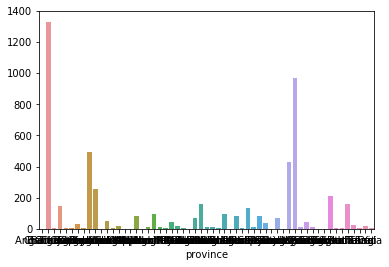

In [26]:
sns.barplot(by_prov_counts.index, by_prov_counts.tolist())
plt.show()

/usr/local/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


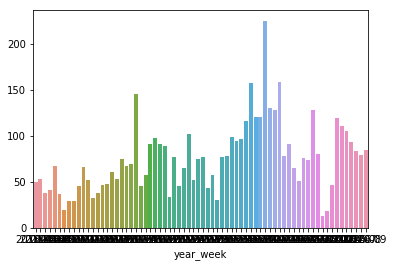

In [27]:
sns.barplot(by_week_counts.index, by_week_counts.tolist())
plt.show()

30


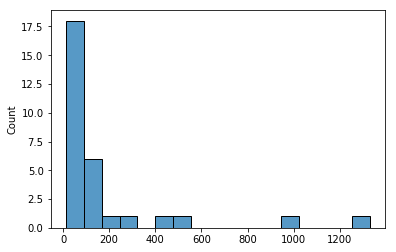

In [28]:
print(len([n for n in by_prov_counts.tolist() if n>10]))
sns.histplot([n for n in by_prov_counts.tolist() if n>10])
plt.show()

57


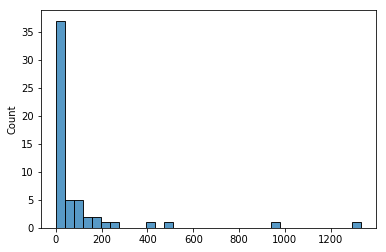

In [29]:
print(len(by_prov_counts.tolist()))
sns.histplot(by_prov_counts.tolist())
plt.show()

In [30]:
by_prov_counts.tolist()

[1.0,
 1331.0,
 3.0,
 147.0,
 2.0,
 5.0,
 34.0,
 6.0,
 496.0,
 254.0,
 1.0,
 47.0,
 4.0,
 15.0,
 1.0,
 1.0,
 84.0,
 1.0,
 9.0,
 95.0,
 14.0,
 2.0,
 41.0,
 18.0,
 3.0,
 1.0,
 71.0,
 158.0,
 10.0,
 14.0,
 6.0,
 95.0,
 1.0,
 80.0,
 2.0,
 132.0,
 9.0,
 82.0,
 36.0,
 1.0,
 70.0,
 1.0,
 431.0,
 970.0,
 12.0,
 43.0,
 12.0,
 1.0,
 1.0,
 213.0,
 5.0,
 8.0,
 160.0,
 27.0,
 3.0,
 20.0,
 4.0]

In [31]:
df.province.unique()

array(['Ang Thong', 'Bangkok', 'Buri Ram', 'Chachoengsao', 'Chaiyaphum',
       'Chanthaburi', 'Chiang Mai', 'Chiang Rai', 'Chonburi', 'Chumphon',
       'Kamphaeng Phet', 'Kanchanaburi', 'Khon Kaen', 'Krabi', 'Lampang',
       'Lamphun', 'Lopburi', 'Mae Hong Son', 'Nakhon Nayok',
       'Nakhon Pathom', 'Nakhon Phanom', 'Nakhon Ratchasima',
       'Nakhon Sawan', 'Nakhon Si Thammarat', 'Narathiwat', 'Nong Khai',
       'Nonthaburi', 'Pathum Thani', 'Pattani', 'Phang Nga', 'Phetchabun',
       'Phetchaburi', 'Phitsanulok', 'Phra Nakhon Si Ayutthaya', 'Phrae',
       'Phuket', 'Prachin Buri', 'Prachuap Khiri Khan', 'Ranong',
       'Ratchaburi', 'Rayong', 'Sakon Nakhon', 'Samut Prakan',
       'Samut Sakhon', 'Samut Songkhram', 'Saraburi', 'Satun', 'Si Saket',
       'Sing Buri', 'Songkhla', 'Sukhothai', 'Suphanburi', 'Surat Thani',
       'Tak', 'Trang', 'Trat', 'Yala'], dtype=object)

In [32]:
by_prov_counts[by_prov_counts>50]

province
Bangkok                     1331.0
Chachoengsao                 147.0
Chonburi                     496.0
Chumphon                     254.0
Lopburi                       84.0
Nakhon Pathom                 95.0
Nonthaburi                    71.0
Pathum Thani                 158.0
Phetchaburi                   95.0
Phra Nakhon Si Ayutthaya      80.0
Phuket                       132.0
Prachuap Khiri Khan           82.0
Rayong                        70.0
Samut Prakan                 431.0
Samut Sakhon                 970.0
Songkhla                     213.0
Surat Thani                  160.0
Name: wv_count, dtype: float64

In [38]:
large_provinces = by_prov_counts[by_prov_counts>50].index.tolist()
large_provinces

['Bangkok',
 'Chachoengsao',
 'Chonburi',
 'Chumphon',
 'Lopburi',
 'Nakhon Pathom',
 'Nonthaburi',
 'Pathum Thani',
 'Phetchaburi',
 'Phra Nakhon Si Ayutthaya',
 'Phuket',
 'Prachuap Khiri Khan',
 'Rayong',
 'Samut Prakan',
 'Samut Sakhon',
 'Songkhla',
 'Surat Thani']

In [41]:
print(wv_data_file)
df = pd.read_csv(data_dir + 'regression_data_%s.csv' % wv_data_file)
print(df.shape)
df = df[df.province.isin(large_provinces)]
print(df.shape)
df.head()

wv_cases4
(3990, 13)
(1190, 13)


,province,year_week,total_demand,perc_abuse,wv_count,ex_rate,fake_date,month,quarter,ex_rate_diff_1,ex_rate_diff_2,ex_rate_diff_3,ex_rate_diff_4
70,Bangkok,2018-45,756.0,0.000000,7.0,4.81420,2018-11-05,2018-11,2018-4,-0.00872,0.023825,0.050075,0.003020
71,Bangkok,2018-46,992.0,0.083333,12.0,4.80816,2018-11-12,2018-11,2018-4,-0.00604,-0.014760,0.017785,0.044035
72,Bangkok,2018-47,628.0,0.000000,8.0,4.81508,2018-11-19,2018-11,2018-4,0.00692,0.000880,-0.007840,0.024705
73,Bangkok,2018-48,970.0,0.000000,8.0,4.80784,2018-11-26,2018-11,2018-4,-0.00724,-0.000320,-0.006360,-0.015080
74,Bangkok,2018-49,712.0,0.000000,14.0,4.82025,2018-12-03,2018-12,2018-4,0.01241,0.005170,0.012090,0.006050


In [40]:
df.to_csv(data_dir + 'regression_data_large_p_%s.csv' % wv_data_file, index=False)

<h1>check WV industry availability</h1>

In [15]:
suppliers = pd.read_csv(data_dir+'suppliers.csv')
suppliers.head()

,Unnamed: 0,id,name,created,tier_id,address,zipcode,gps,vessel_number,fishing_gear_liscense_number,...,other,country_id,district_id,industry_id,province_id,vessel_type_id,total_num_men_workers,total_num_women_workers,subindustry_id,golden_dreams_employer_id
0,0,1,89 Subcharoen,2020-01-16,NaN,-,-,-,-,NaN,...,NaN,NaN,NaN,21.0,NaN,NaN,NaN,NaN,9.0,NaN
1,1,2,A. Anon,2020-01-16,NaN,-,-,-,-,NaN,...,NaN,NaN,NaN,16.0,NaN,NaN,NaN,NaN,NaN,NaN
2,2,3,A. Arunsamut 1,2020-01-16,NaN,-,-,-,-,NaN,...,NaN,8.0,46.0,16.0,NaN,129.0,NaN,NaN,NaN,NaN
3,3,4,A. Arunsamut 6,2020-01-16,NaN,-,-,-,-,NaN,...,NaN,8.0,46.0,16.0,NaN,129.0,NaN,NaN,NaN,NaN
4,4,5,A. Arunsamut 7,2020-01-16,NaN,-,-,-,-,NaN,...,NaN,8.0,46.0,16.0,NaN,129.0,NaN,NaN,NaN,NaN


In [16]:
wv_data = cases1
wv_data_w_industry = pd.merge(wv_data, suppliers[['id', 'industry_id']], left_on='supplier_id', right_on='id', how='left')
wv_data_w_industry.head()

,created,client_ethnicity_id,client_gender_id,client_nationality_id,client_status_id,country_id,district_id,province_id,client_origin_country_id,client_origin_province_id,supplier_id,kpi_id,id_x,Boyu - abuse including RA,abuse,year_week,id_y,industry_id
0,2018-11-17,1.0,1.0,5.0,3.0,8.0,NaN,70.0,8.0,51.0,5685.0,NaN,NaN,NaN,False,2018-46,5685.0,11.0
1,2018-11-18,1.0,2.0,5.0,3.0,8.0,367.0,119.0,8.0,49.0,391.0,55.0,55.0,0.0,False,2018-46,391.0,16.0
2,2018-11-17,NaN,1.0,5.0,3.0,8.0,NaN,105.0,8.0,NaN,1083.0,29.0,29.0,1.0,True,2018-46,1083.0,NaN
3,2018-11-19,1.0,1.0,5.0,3.0,8.0,NaN,114.0,8.0,51.0,NaN,NaN,NaN,NaN,False,2018-47,NaN,NaN
4,2018-11-19,1.0,1.0,5.0,11.0,8.0,369.0,77.0,8.0,49.0,5685.0,NaN,NaN,NaN,False,2018-47,5685.0,11.0


In [17]:
sum(pd.isnull(wv_data_w_industry.industry_id)), wv_data_w_industry.shape[0]

(5428, 8951)

In [21]:
wv_data_w_industry['year'] = wv_data_w_industry['created'].apply(lambda x: x.split('-')[0])
# wv_data_w_industry['year'].hist()
# plt.show()

In [19]:
sum(pd.isnull(wv_data_w_industry.province_id))

0

In [24]:
sum(pd.isnull(wv_data_w_industry[wv_data_w_industry.year=='2019'].industry_id)), wv_data_w_industry[wv_data_w_industry.year=='2019'].shape[0]

(2446, 4236)